In [ ]:
# !pip install mysql-connector-python statsmodels 

In [1]:
import pandas as pd
from get_sdams_db import GetSdamsDB
import numpy as np
from tqdm import tqdm
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/Data/FoodDetection/AI_OCR/Whatiswrong/')
sys.path.append('/Data/FoodDetection/AI_OCR/Scatter/')
import augs
import matplotlib.pyplot as plt
from albumentations.augmentations.transforms import Normalize
from albumentations import GaussNoise, IAAAdditiveGaussianNoise, Compose, OneOf, HorizontalFlip, ShiftScaleRotate
from albumentations.pytorch import ToTensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import utils
from PIL import Image
device = torch.device('cuda')
experiment_name = f'{utils.SaveDir_maker(base_model = "pd_clf", base_model_dir = "./models")}'
from tqdm import tqdm
import os
from scipy.stats import gaussian_kde

In [2]:
pd2nz = os.listdir('./noise_images_1/')
nz2nz = os.listdir('./noise_images_2/')
pd2pd = os.listdir('./pd_images_1')

pd2nz_idx = [int(x.replace('.png', '')) for x in pd2nz]
nz2nz_idx = [int(x.replace('.png', '')) for x in nz2nz]
pd2pd_idx = [int(x.replace('.png', '')) for x in pd2pd]

In [3]:
with open('pd_coord', 'rb') as file:
    pd_coord = pickle.load(file)

with open('nz_coord', 'rb') as file:
    nz_coord = pickle.load(file)

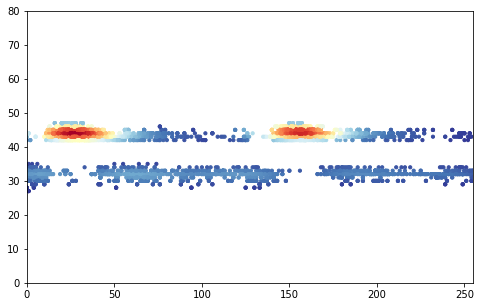

In [46]:
## 'pd_images/230.png'
# cm = plt.cm.get_cmap('RdYlBu')
# plt.figure(figsize=(8,5))
# plt.axis([0, 255, 0, 80])
# x = np.array(pd_coord[pd2nz_idx[-1]])[:,1]
# y = np.array(pd_coord[pd2nz_idx[-1]])[:,0]
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# plt.scatter(x, y ,c=-z, s=10, cmap=cm)

In [4]:
pd_coord_new = []
nz_coord_new = []
for idx in pd2nz_idx:
    nz_coord_new.append(pd_coord[idx])
for idx in nz2nz_idx:
    nz_coord_new.append(nz_coord[idx])
for idx in pd2pd_idx:
    pd_coord_new.append(pd_coord[idx])

In [21]:
pd2pd_idx[7]

105

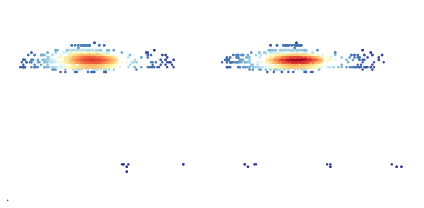

In [22]:
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(6,3))
plt.ylim(0,80) 
plt.xlim(0, 254)
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axes().set_frame_on(False)
plt.tight_layout()
x = np.asarray(pd_coord[105])[:,1]
y = np.asarray(pd_coord[105])[:,0],
xy = np.vstack([x,y])  ###
z = gaussian_kde(xy)(xy) ###
plt.scatter(x, y , s=2, c= -z, cmap=cm ) ###

In [55]:
print(len(nz_coord_new))
print(len(pd_coord_new))

2292
306


In [56]:
# with open('pd_coord_new', 'wb') as file:
#     pickle.dump(pd_coord_new, file)
    
# with open('nz_coord_new', 'wb') as file:
#     pickle.dump(nz_coord_new, file)

In [5]:
with open('pd_coord_new', 'rb') as file:
    pd_coord_new = pickle.load(file)

with open('nz_coord_new', 'rb') as file:
    nz_coord_new = pickle.load(file)

In [6]:
def Dataset_with_Label(data, label):
    dataset_with_label = []
    for i in range(len(data)):
        dataset_with_label.append([data[i], label])
    return dataset_with_label

In [7]:
pd_dataset = Dataset_with_Label(pd_coord_new, 1)
nz_dataset = Dataset_with_Label(nz_coord_new, 0)

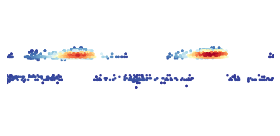

In [5]:
# # test intensity color
# cm = plt.cm.get_cmap('RdYlBu')
# idx = 0
# fig = plt.figure(figsize=(4,2))
# plt.ylim(0,80)
# plt.xlim(0, 254)
# # plt.axes().axis('off')
# x = np.asarray(pd_dataset[idx][0])[:,1]
# y = np.asarray(pd_dataset[idx][0])[:,0]
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# plt.axes().get_xaxis().set_visible(False)
# plt.axes().get_yaxis().set_visible(False)
# plt.axes().set_frame_on(False)
# plt.tight_layout()
# plt.scatter(x, y , c=-z, s=2, cmap=cm)

In [13]:
# # for deploy
# class Custom_dataset(Dataset):
#     def __init__(self, coord_data):
#         self.dataset = coord_data
#         self.tensor =  ToTensor()
#         self.normalize = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         self.cm = plt.cm.get_cmap('RdYlBu')
        
#     def __len__(self):
#         return len(self.dataset)
    
#     def __getitem__(self, idx):
#         point_coord  = self.dataset[idx]
        
#         # 좌표를 이미지로 
#         fig = plt.figure(figsize=(4,2))
#         plt.ylim(0,80) 
#         plt.xlim(0, 254)
#         plt.axes().get_xaxis().set_visible(False)
#         plt.axes().get_yaxis().set_visible(False)
#         plt.axes().set_frame_on(False)
#         plt.tight_layout()
#         x = np.asarray(point_coord)[:,1] ###
#         y = np.asarray(point_coord)[:,0] ###
#         xy = np.vstack([x,y])  ###
#         z = gaussian_kde(xy)(xy) ###
#         plt.scatter(x, y , s=2, c= -z, cmap=self.cm ) ###
#         plt.close()
        
#         # 이미지를 array 로
#         fig.canvas.draw()
#         img_arr = np.array(fig.canvas.renderer._renderer)[:, :, :3]
        
#         # normalize 기존 정규화방식과 다르다
#         img_arr = self.normalize(**{'image' : img_arr})['image']
        
#         return self.tensor(**{'image' : img_arr})['image']

In [ ]:
pd_custom = Custom_dataset(pd_coord)

In [8]:
# for develop
class Custom_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.tensor =  ToTensor()
        self.normalize = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        self.cm = plt.cm.get_cmap('RdYlBu')
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        point_coord, label = self.dataset[idx]
        
        # plotting
        fig = plt.figure(figsize=(4,2))
        plt.ylim(0,80)
        plt.xlim(0, 254)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        plt.axes().set_frame_on(False)
        plt.tight_layout()
        x = np.asarray(point_coord)[:,1]
        y = np.asarray(point_coord)[:,0]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        plt.scatter(x, y , s=2, c= -z, cmap=self.cm )
        plt.close()
        
        # convert to array
        fig.canvas.draw()
        img_arr = np.array(fig.canvas.renderer._renderer)[:, :, :3]
        # normalize
        img_arr = self.normalize(**{'image' : img_arr})['image'] 
        
        if self.transform:
            return (self.transform(**{'image' : img_arr})['image'], label)
            
        else:
            return (self.tensor(**{'image' : img_arr})['image'], label)

In [9]:
transformers = Compose([
                            augs.GridMask(num_grid=(5,10)),
                            HorizontalFlip(p=0.7), 
                            ShiftScaleRotate(rotate_limit = 0, scale_limit = 0.01, shift_limit=0.4, p=0.9) ,
                            ToTensor() 
                       ])

In [10]:
pd_train = pd_dataset[ : int(len(pd_dataset) * 0.9)]
pd_valid = pd_dataset[int(len(pd_dataset) * 0.9) : ]

nz_train = nz_dataset[ : int(len(nz_dataset) * 0.9)]
nz_valid = nz_dataset[int(len(nz_dataset) * 0.9) : ]

print('before extend : ',len(nz_valid))
nz_valid.extend(pd_valid)
print('after extend : ',len(nz_valid))

before extend :  230
after extend :  261


In [15]:
batch_size = 20
epoch = 4
grad_clip = 5
num_workers = 2

pd_custom = Custom_dataset(pd_train, transform=transformers)
nz_custom = Custom_dataset(nz_train, transform=transformers)
valid_custom = Custom_dataset(nz_valid)

pd_sampler = torch.utils.data.RandomSampler(pd_custom, True, int(max(len(pd_custom), len(nz_custom)))*(epoch))
nz_sampler = torch.utils.data.RandomSampler(nz_custom, True, int(max(len(pd_custom), len(nz_custom)))*(epoch))

pd_loader = DataLoader(pd_custom, batch_size = batch_size, sampler=pd_sampler, num_workers=num_workers, pin_memory=True)
nz_loader = DataLoader(nz_custom, batch_size = batch_size, sampler=nz_sampler, num_workers=num_workers, pin_memory=True)
valid_loader = DataLoader(valid_custom, batch_size = batch_size, shuffle=True, num_workers=0, pin_memory=True)

pd_iter = iter(pd_loader)
nz_iter = iter(nz_loader)
valid_iter = iter(valid_loader)

iter_per_epoch = len(pd_loader)//epoch

In [15]:
# img, label = next(pd_iter)

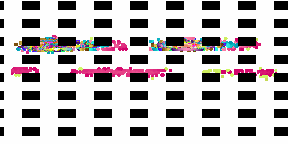

In [17]:
# transforms.ToPILImage()(img[2])

# train

In [32]:
# load_path = './models/pd_clf_0909/0/best_accuracy_0.59.pth'
load_path = False

os.makedirs(f'./models/{experiment_name}', exist_ok=True)


# model = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes' : 1})
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1, in_channels=3)

if load_path:
    model.load_state_dict(torch.load(load_path))
    print('load_complete')
model = model.to(device)

#data parallel for multi GPU
model = torch.nn.DataParallel(model).to(device)
model.train() 

# loss
criterion = torch.nn.BCEWithLogitsLoss().to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)

# filter that only require gradient descent
# filtered_parameters = []
# params_num = []
# for p in filter(lambda p : p.requires_grad, model.parameters()):
#     filtered_parameters.append(p)
#     params_num.append(np.prod(p.size()))
# print('Tranable params : ', sum(params_num))

#optimizer
# optimizer = torch.optim.AdamW(filtered_parameters)
optimizer = torch.optim.Adadelta(model.parameters())
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience = 2, factor= 0.5 )

# log
with open(f'./models/{experiment_name}/opt.txt', 'a') as opt_file:
    opt_log = '---------------------Options-----------------\n'
    opt_log +=f'batch size : {batch_size}\n'
    opt_log +=f'epoch : {epoch}\n'
    opt_log +='---------------------------------------------\n'
    opt_file.write(opt_log)

best_accuracy = 0
for epoc in range(epoch):
    for step in range(iter_per_epoch):

        if step%2==0:
            img, label = next(pd_iter)
        else:
            img, label = next(nz_iter)

        img = img.to(device)
#         label = label.to(device)
        logit = model(img)
        
        loss = criterion(logit.squeeze(1), label.type(torch.FloatTensor).to(device))
        loss_avg = utils.Averager()
        loss_avg.add(loss)

        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
#         print(loss_avg.val())

    #validation
    valid_iter = iter(valid_loader)
    valid_loss_avg = utils.Averager()
    batch_acc = 0
    with open(f'./models/{experiment_name}/log_train.txt', 'a') as log:
        model.eval()
        with torch.no_grad():
            for val_step in range(len(valid_iter)):

                img, label = next(valid_iter)
                img = img.to(device)
                each_batch_size = img.size(0)

                logit = model(img)
                val_loss = criterion(logit.squeeze(1), label.type(torch.FloatTensor).to(device))
                valid_loss_avg.add(val_loss)

                pred = torch.where(torch.sigmoid(logit) > 0.5, torch.Tensor([1]).to(device), torch.Tensor([0]).to(device))
#                 _, pred = logit.max(1)
#                 print('logit : ', logit.squeeze(1))
                print('pred  : ', pred.squeeze(1).type(torch.LongTensor))
                print('label : ', label)
                batch_true = torch.sum(pred == label.reshape(each_batch_size, 1).to(device)).item()

                batch_acc += (batch_true/each_batch_size)
            print(batch_acc)
        
        valid_acc = batch_acc / len(valid_iter)
        model.train()
        loss_log = f'[epoch : {epoc}/{epoch}]\nTrain loss : {loss_avg.val():0.5f}, valid loss : {valid_loss_avg.val():0.5f}'            
        valid_log = f'{"current accuracy":17s} : {valid_acc:0.3f}'
        best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}'
        loss_model_log = f'{loss_log}\n{valid_log}\n{best_model_log}\n{"-"*80}'
        log.write(loss_model_log+'\n')
    if best_accuracy < valid_acc :
        best_accuracy = valid_acc
        torch.save(model.module.state_dict(), f'./models/{experiment_name}/best_accuracy_{round(best_accuracy,2)}.pth')
        

Loaded pretrained weights for efficientnet-b0
pred  :  tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1])
label :  tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])
pred  :  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [12]:
torch.sigmoid(logit)

tensor([[0.2874],
        [0.3341],
        [0.2267],
        [0.2759],
        [0.1573]], device='cuda:0')

In [39]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1, in_channels=3)
model.load_state_dict(torch.load('./models/pd_clf_0911/0/best_accuracy_0.88.pth'))
model = model.to(device)
_ = model.eval()

Loaded pretrained weights for efficientnet-b0


In [40]:
img, label  = next(valid_iter)

In [41]:
logit = model(img.to(device))

In [42]:
torch.sigmoid(logit)

tensor([[0.3866],
        [0.7143],
        [0.1180],
        [0.1658],
        [0.3079],
        [0.2015],
        [0.4720],
        [0.3096],
        [0.2398],
        [0.5395],
        [0.2878],
        [0.4061],
        [0.2438],
        [0.3144],
        [0.4299],
        [0.5786],
        [0.8083],
        [0.2334],
        [0.2539],
        [0.5223]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [43]:
label

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])